In [1]:
import time
import rospy
import cv2
import kornia as K
import kornia.feature as KF
import rosbag
import os
import sys
import numpy as np

from sensor_msgs.msg import Image, JointState
from message_filters import ApproximateTimeSynchronizer, Subscriber

# set random seed
np.random.seed(0)

from RobotLink_kornia import *
from StereoCamera_kornia import *
from ParticleFilter_kornia import *
from probability_functions_kornia import *
from utils_kornia import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Dataset types
fei_dataset = True

if fei_dataset:
    robot_file    = '../../fei_dataset/LND.json'
    camera_file   = '../../fei_dataset/camera_calibration.yaml'
    hand_eye_file = '../../fei_dataset/handeye.yaml'

    left_camera_topic  = '/stereo/left/image'
    right_camera_topic = '/stereo/right/image'
    robot_joint_topic  = '/dvrk/PSM2/state_joint_current'
    robot_gripper_topic = '/dvrk/PSM2/state_jaw_current'

    bag_path = '../../fei_dataset/volume_4points_t2.bag'
    source_dir = 'fei_ref_data/'

else:
    robot_file    = '../../journal_dataset/LND.json'
    camera_file   = '../../journal_dataset/camera_calibration.yaml'
    hand_eye_file = '../../journal_dataset/handeye.yaml'

    left_camera_topic  = '/stereo/left/image'
    right_camera_topic = '/stereo/right/image'
    robot_joint_topic  = '/dvrk/PSM1/state_joint_current'
    robot_gripper_topic = '/dvrk/PSM1/state_jaw_current'

    bag_path = '../../journal_dataset/stationary_camera_2020-06-24-15-49-10.bag'
    source_dir = 'ref_data/no_contour/'

In [3]:
# Load reference image data for SOLD2
# -- Crop info
crop_scale = np.load(source_dir + 'crop_scale.npy')

# -- Reference line idx
crop_ref_lines_l_idx = np.load(source_dir + 'crop_ref_lines_l_idx.npy') # torch.Size([2, 2, 2]) # endpoints per line: [y, x] [y, x]
crop_ref_lines_r_idx = np.load(source_dir + 'crop_ref_lines_r_idx.npy') # torch.Size([2, 2, 2]) # endpoints per line: [y, x] [y, x]

# -- Ref lines
crop_ref_lines_l = torch.from_numpy(np.load(source_dir + 'crop_ref_lines_l.npy')).to(device)
crop_ref_lines_r = torch.from_numpy(np.load(source_dir + 'crop_ref_lines_r.npy')).to(device)

# -- Line descriptors
crop_ref_desc_l = torch.from_numpy(np.load(source_dir + 'crop_ref_desc_l.npy')).to(device)
crop_ref_desc_r = torch.from_numpy(np.load(source_dir + 'crop_ref_desc_r.npy')).to(device)


# reference images
# left camera
crop_ref_l_img = source_dir + 'ref_left_img.jpg'
crop_ref_l_img = cv2.imread(crop_ref_l_img, cv2.IMREAD_COLOR)
crop_ref_l_img = cv2.cvtColor(crop_ref_l_img, cv2.COLOR_BGR2RGB)
img_dims = (int(crop_ref_l_img.shape[1]), int(crop_ref_l_img.shape[0]))
crop_ref_l_tensor = K.image_to_tensor(crop_ref_l_img).float() / 255.0 # [0, 1] torch.Size([3, 720, 1080]) torch.float32
crop_ref_l_tensor = K.enhance.sharpness(crop_ref_l_tensor, 5.0)
crop_ref_l_tensor = K.enhance.adjust_saturation(crop_ref_l_tensor, 5.0)
crop_ref_l_tensor = K.color.rgb_to_grayscale(crop_ref_l_tensor) # [0, 1] torch.Size([1, 720, 1080]) torch.float32
crop_ref_l_tensor = crop_ref_l_tensor.to(device)

# right camera
crop_ref_r_img = source_dir + 'ref_right_img.jpg'
crop_ref_r_img = cv2.imread(crop_ref_r_img, cv2.IMREAD_COLOR)
crop_ref_r_img = cv2.cvtColor(crop_ref_r_img, cv2.COLOR_BGR2RGB)
crop_ref_r_tensor = K.image_to_tensor(crop_ref_r_img).float() / 255.0 # [0, 1] torch.Size([3, 720, 1080]) torch.float32
crop_ref_r_tensor = K.enhance.sharpness(crop_ref_r_tensor, 5.0)
crop_ref_r_tensor = K.enhance.adjust_saturation(crop_ref_r_tensor, 5.0)
crop_ref_r_tensor = K.color.rgb_to_grayscale(crop_ref_r_tensor) # [0, 1] torch.Size([1, 720, 1080]) torch.float32
crop_ref_r_rensor = crop_ref_r_tensor.to(device)

print("Cropping {}".format(crop_scale))
print("Image dimensions {}".format(img_dims))

# Load kornia model
model = KF.SOLD2(pretrained=True, config=None)
model.to(device)

Cropping 1
Image dimensions (960, 540)


SOLD2(
  (model): SOLD2Net(
    (backbone_net): HourglassBackbone(
      (net): HourglassNet(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (layer1): Sequential(
          (0): Bottleneck2D(
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 1

In [4]:
# Prepare camera and robot arm
robot_arm = RobotLink(robot_file, use_dh_offset=False) # position / orientation in Meters
cam = StereoCamera(camera_file, rectify = True, crop_scale = crop_scale, downscale_factor = 2, scale_baseline=1e-3)

# Load handeye info
f = open(hand_eye_file)
hand_eye_data = yaml.load(f, Loader=yaml.FullLoader)
cam_T_b = np.eye(4)
if fei_dataset:
    cam_T_b[:-1, -1] = np.array(hand_eye_data['PSM2_tvec'])/1000.0 # convert to mm
    cam_T_b[:-1, :-1] = axisAngleToRotationMatrix(hand_eye_data['PSM2_rvec'])
else:
    cam_T_b[:-1, -1] = np.array(hand_eye_data['PSM1_tvec'])/1000.0 # convert to mm
    cam_T_b[:-1, :-1] = axisAngleToRotationMatrix(hand_eye_data['PSM1_rvec'])

In [5]:
# Load rosbag for dataset
bag = rosbag.Bag(bag_path)
print("ROSBag duration is: {}".format(bag.get_end_time() - bag.get_start_time()))
print("Message count for l_cam: {}".format(bag.get_message_count(left_camera_topic)))
print("Message count for r_cam: {}".format(bag.get_message_count(right_camera_topic)))
print("Message count for joint: {}".format(bag.get_message_count(robot_joint_topic)))
print("Message count for gripper: {}".format(bag.get_message_count(robot_gripper_topic)))

ROSBag duration is: 45.347689628601074
Message count for l_cam: 1358
Message count for r_cam: 1357
Message count for joint: 4499
Message count for gripper: 4499


In [6]:
# parameters for shaft detection
# CHRIS WENT CRAZY WITH THESE PARAMETERS!!!!!!!!
canny_params = {
    'use_canny': False,
    'hough_rho_accumulator': 5.0,
    'hough_theta_accumulator': 0.09,
    'hough_vote_threshold': 100,
    'rho_cluster_distance': 5.0,
    'theta_cluster_distance': 0.09
}

kornia_params = {
    'use_kornia': True,
    'endpoints_to_polar': False,
    'use_endpoint_intensities_only': False,
    'endpoint_intensities_to_polar': True,
    'search_radius': 3.0,
    'intensity_params': {
        'use_metric': 'pct',
        'mean': 0,
        'std': 1.0,
        'pct': 10.0
    },
    'ransac_params': {
        'num_iterations': 5, #5
        'min_samples': 3.0,
        'residual_threshold': 0.75, #0.75
        'max_trials': 100,
        'img_dims': img_dims
    },
    'use_line_intensities_only': False,
    'line_intensities_to_polar': False
} 


In [150]:
frame_counter = 0

# Video output writer
video_out  = cv2.VideoWriter("handeye.mp4",  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 30, (int(img_dims[0]*2), img_dims[1]))

# Params for sync approach
old_l_img_msg = None
old_r_img_msg = None
l_img_msg = None
r_img_msg = None
j_msg = None
g_msg = None

run_sold2_detection = False

max_num_lines_to_store = 5
l_detected_lines = []
r_detected_lines = []
j_angles = []

for topic, msg, t in bag.read_messages(topics=[left_camera_topic, right_camera_topic, robot_joint_topic, robot_gripper_topic]):
    # Store new messages
    if topic == left_camera_topic:
        old_l_img_msg = copy.deepcopy(l_img_msg)
        l_img_msg = copy.deepcopy(msg)
        l_img_t = t
    if topic == right_camera_topic:
        old_r_img_msg = copy.deepcopy(r_img_msg)
        r_img_msg = copy.deepcopy(msg)
        r_img_t = t
    if topic == robot_joint_topic:
        j_msg = copy.deepcopy(msg)
        j_msg_t = t
    if topic == robot_gripper_topic:
        g_msg = copy.deepcopy(msg)
        g_msg_t = t
    
    # Sync
    if ((l_img_msg != None) and (r_img_msg != None)) and ((l_img_msg != old_l_img_msg) and (r_img_msg != old_r_img_msg)) \
        and (j_msg) and (g_msg):
        try:
            l_img  = np.ndarray(shape=(l_img_msg.height, l_img_msg.width, 3), dtype=np.uint8, buffer=l_img_msg.data)
            r_img = np.ndarray(shape=(r_img_msg.height, r_img_msg.width, 3), dtype=np.uint8, buffer=r_img_msg.data)
            new_joint_angles = np.array(j_msg.position + g_msg.position)
        except:
            continue

        # Previously did not have this !!!!
        old_l_img_msg = copy.deepcopy(l_img_msg)
        old_r_img_msg = copy.deepcopy(r_img_msg)
        frame_counter += 1

    else:
        continue
    
    # Check how desync'ed we are here
    desync_r_img = np.abs(l_img_t.to_sec() - r_img_t.to_sec())
    desync_joint = np.abs(l_img_t.to_sec() - j_msg_t.to_sec())
    desync_gripper = np.abs(l_img_t.to_sec() - g_msg_t.to_sec())
    if desync_r_img > 1/30:
        print("Desynced left and right by {} at frame {}".format(desync_r_img, frame_counter))
    if desync_joint > 1/50:
        print("Desynced left and joint by {} at frame {}".format(desync_joint, frame_counter))
    if desync_gripper > 1/50:
        print("Desynced left and gripper by {} at frame {}".format(desync_gripper, frame_counter))

    # Update robot joint angles
    robot_arm.updateJointAngles(new_joint_angles)

    # Pre-process the images
    l_img, r_img = cam.processImage(l_img, r_img, crop_scale = crop_scale)
    
    
    # Run SOLD2 for shaft detection
    output_l  = detectShaftLines(
                                non_annotated_img = l_img,
                                annotated_img = l_img,
                                ref_img = crop_ref_l_img,
                                ref_tensor = crop_ref_l_tensor,
                                crop_ref_lines = crop_ref_lines_l,
                                crop_ref_lines_idx = crop_ref_lines_l_idx,
                                crop_ref_desc = crop_ref_desc_l,
                                model = model,
                                device = device,
                                draw_lines = True,
                                canny_params = canny_params,
                                kornia_params = kornia_params
                                )
    output_r  = detectShaftLines(
                                non_annotated_img = r_img,
                                annotated_img = r_img,
                                ref_img = crop_ref_r_img,
                                ref_tensor = crop_ref_r_tensor,
                                crop_ref_lines = crop_ref_lines_r,
                                crop_ref_lines_idx = crop_ref_lines_r_idx,
                                crop_ref_desc = crop_ref_desc_r,
                                model = model,
                                device = device,
                                draw_lines = True,
                                canny_params = canny_params,
                                kornia_params = kornia_params
                                )
    
    # Save detections
    l_lines = output_l['intensity_endpoint_lines']
    r_lines = output_r['intensity_endpoint_lines']
    
    #   -- Fill in missed detections as NAN and clip to 5 detections
    if l_lines is None:
        l_lines = []
    while len(l_lines) < max_num_lines_to_store:
        l_lines.append([np.NAN, np.NAN])
    if len(l_lines) > max_num_lines_to_store:
        l_lines = l_lines[:max_num_lines_to_store]

    if r_lines is None:
        r_lines = []
    while len(r_lines) < max_num_lines_to_store:
        r_lines.append([np.NAN, np.NAN])
    if len(r_lines) > max_num_lines_to_store:
        r_lines = r_lines[:max_num_lines_to_store]

    #   -- Save to ouptput lists
    l_detected_lines.append(l_lines)
    r_detected_lines.append(r_lines)
    j_angles.append(new_joint_angles)
    
    # Get plotted iamges
    l_img  = np.copy(output_l['new_img']) # cropped img w/detected lines
    r_img  = np.copy(output_r['new_img']) # cropped img w/detected lines

    # Plot skeleton of surgical tool
    img_list = projectSkeleton(robot_arm.getSkeletonPoints(), cam_T_b, [l_img, r_img], cam.projectPoints)

    # Write image to video here
    img_to_disp = np.concatenate([l_img, r_img], axis=1)
    img_to_disp = cv2.cvtColor(img_to_disp, cv2.COLOR_BGR2RGB)
    video_out.write(img_to_disp)

    # if frame_counter > 100:
    #     break

video_out.release()

l_detected_lines = np.array(l_detected_lines)
r_detected_lines = np.array(r_detected_lines)
j_angles = np.array(j_angles)

np.savez('handeye', l_detected_lines = l_detected_lines, r_detected_lines = r_detected_lines, j_angles = j_angles)

sold2 line detection took 1.8521 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 1.9316 seconds
sold2 line detection took 0.1434 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0023 seconds
Function detectShaftLines Took 0.2092 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1435 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0057 seconds
Function detectShaftLines Took 0.2099 seconds
sold2 line detection took 0.1442 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2080 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1432 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1445 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0052 seconds
Function detectShaftLines Took 0.2065 seconds
sold2 line detection took 0.1354 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0029 seconds
Function detectShaftLines Took 0.1875 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1433 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0064 seconds
Function detectShaftLines Took 0.2102 seconds
sold2 line detection took 0.1414 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.2020 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1347 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0112 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1452 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0059 seconds
Function detectShaftLines Took 0.2172 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1463 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0052 seconds
Function detectShaftLines Took 0.2091 seconds
sold2 line detection took 0.1522 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0040 seconds
Function detectShaftLines Took 0.2094 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1791 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0104 seconds
Function detectShaftLines Took 0.2468 seconds
sold2 line detection took 0.1422 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1526 seconds
sold2 line matching took 0.0082 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2180 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1591 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0056 seconds
Function detectShaftLines Took 0.2244 seconds
sold2 line detection took 0.1392 seconds
sold2 line matching took 0.0077 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.1972 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1709 seconds
sold2 line matching took 0.0083 seconds
Function fitRansacLines Took 0.0063 seconds
Function detectShaftLines Took 0.2432 seconds
sold2 line detection took 0.1615 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0048 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1398 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0086 seconds
Function detectShaftLines Took 0.2125 seconds
sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2122 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1590 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.2274 seconds
sold2 line detection took 0.1401 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2009 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1413 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0059 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1666 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0079 seconds
Function detectShaftLines Took 0.2334 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1749 seconds
sold2 line matching took 0.0137 seconds
Function fitRansacLines Took 0.0046 seconds
Function detectShaftLines Took 0.2413 seconds
sold2 line detection took 0.1424 seconds
sold2 line matching took 0.0088 seconds
Function fitRansacLines Took 0.0063 seconds
Function detectShaftLines Took 0.2061 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1452 seconds
sold2 line matching took 0.0081 seconds
Function fitRansacLines Took 0.0108 seconds
Function detectShaftLines Took 0.2150 seconds
sold2 line detection took 0.1367 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0056 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1504 seconds
sold2 line matching took 0.0090 seconds
Function fitRansacLines Took 0.0048 seconds
Function detectShaftLines Took 0.2206 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1455 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0082 seconds
Function detectShaftLines Took 0.2136 seconds
sold2 line detection took 0.1388 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0035 seconds
Function detectShaftLines Took 0.1967 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1418 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2065 seconds
sold2 line detection took 0.1452 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0048 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1451 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0057 seconds
Function detectShaftLines Took 0.2102 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1646 seconds
sold2 line matching took 0.0090 seconds
Function fitRansacLines Took 0.0071 seconds
Function detectShaftLines Took 0.2389 seconds
sold2 line detection took 0.1641 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0094 seconds
Function detectShaftLines Took 0.2338 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1396 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.2134 seconds
sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1398 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0107 seconds
Function detectShaftLines Took 0.2062 seconds
sold2 line detection took 0.1393 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0159 seconds
Function detectShaftLines Took 0.2111 seconds
text_string: None,None,456,130,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1380 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.1909 seconds
sold2 line detection took 0.1368 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0035 seconds
Function detectShaftLines Took 0.1896 seconds
text_string: None,None,456,130,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1426 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1454 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1955 seconds
text_string: None,None,456,130,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1455 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0093 seconds
Function detectShaftLines Took 0.2147 seconds
sold2 line detection took 0.1454 seconds
sold2 line matching took 0.0084 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2137 seconds
text_string: None,None,456,130,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1562 seconds
sold2 line matching took 0.0088 seconds
Function fitRansacLines Took 0.0072 seconds
Function detectShaftLines Took 0.2174 seconds
sold2 line detection took 0.1440 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1511 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0048 seconds
Function detectShaftLines Took 0.2121 seconds
sold2 line detection took 0.1410 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2027 seconds
text_string: None,None,456,130,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1527 seconds
sold2 line matching took 0.0086 seconds
Function fitRansacLines Took 0.0109 seconds
Function detectShaftLines Took 0.2270 seconds
sold2 line detection took 0.1418 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0044 seconds
Function detectShaftLines Took 0.2107 seconds
text_string: None,None,456,130,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1481 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1338 seconds
sold2 line matching took 0.0074 seconds
Function fitRansacLines Took 0.0053 seconds
Function detectShaftLines Took 0.1990 seconds
sold2 line detection took 0.1489 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.2063 seconds
text_string: None,None,452,127,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1411 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0043 seconds
Function detectShaftLines Took 0.1992 seconds
sold2 line detection took 0.1473 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0026 seconds
Function detectShaftLines Took 0.2025 seconds
text_string: None,None,452,127,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1423 seconds
sold2 line matching took 0.0088 seconds
Function fitRansacLines Took 0.0059 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

Function fitRansacLines Took 0.0527 seconds
Function detectShaftLines Took 0.2395 seconds
text_string: None,None,447,124,,

text_string: None,None,447,124,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1378 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.1883 seconds
sold2 line detection took 0.1365 seconds
sold2 line matching took 0.0074 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.1884 seconds
text_string: None,None,447,124,,

text_string: None,None,447,124,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1378 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0053 seconds
Function detectShaftLines Took 0.1975 seconds
sold2 line detection took 0.1365 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0034 seconds
Function detectShaftLines Took 0.1934 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1402 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0098 seconds
Function detectShaftLines Took 0.2168 seconds
sold2 line detection took 0.1353 seconds
sold2 line matching took 0.0101 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.1946 seconds
text_string: None,None,446,124,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1343 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0057 seconds
Function detectShaftLines Took 0.2002 seconds
sold2 line detection took 0.1351 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0023 seconds
Function detectShaftLines Took 0.1926 seconds
text_string: None,None,446,123,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1609 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0044 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1533 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0029 seconds
Function detectShaftLines Took 0.2027 seconds
text_string: None,None,440,119,,

Function projectSkeleton Took 0.0010 seconds
sold2 line detection took 0.1649 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0055 seconds
Function detectShaftLines Took 0.2413 seconds
sold2 line detection took 0.1708 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0025 seconds
Function detectShaftLines Took 0.2255 seconds
text_string: None,None,440,119,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1593 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0063 seconds
Function detectShaftLines Took 0.2260 seconds
sold2 line detection took 0.1733 seconds
sold2 line matching took 0.0122 seconds
Function fitRansacLines Took 0.0026 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1674 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0040 seconds
Function detectShaftLines Took 0.2262 seconds
text_string: None,None,438,118,,

text_string: None,None,438,118,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1474 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2067 seconds
sold2 line detection took 0.1412 seconds
sold2 line matching took 0.0086 seconds
Function fitRansacLines Took 0.0049 seconds
Function detectShaftLines Took 0.1955 seconds
text_string: None,None,438,118,,

Function projectSkeleton Took 0.0012 seconds
sold2 line detection took 0.1516 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0043 seconds
Function detectShaftLines Took 0.2136 seconds
sold2 line detection took 0.1460 seconds
sold2 line matching took 0.0084 seconds
Function fitRansacLines Took 0.0084 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

Function fitRansacLines Took 0.0020 seconds
Function detectShaftLines Took 0.1790 seconds
text_string: None,None,437,117,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1318 seconds
sold2 line matching took 0.0061 seconds
Function fitRansacLines Took 0.0022 seconds
Function detectShaftLines Took 0.1788 seconds
sold2 line detection took 0.1320 seconds
sold2 line matching took 0.0061 seconds
Function fitRansacLines Took 0.0034 seconds
Function detectShaftLines Took 0.1809 seconds
text_string: None,None,437,117,,

text_string: None,None,437,117,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1302 seconds
sold2 line matching took 0.0061 seconds
Function detectShaftLines Took 0.1714 seconds
sold2 line detection took 0.1370 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0047 seconds
Function detectShaftLines Took 0.1935 seconds
text_string: None,None,437,117,,

text_string: None,None,437,117,,

Function p

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

Function fitRansacLines Took 0.0505 seconds
Function detectShaftLines Took 0.2239 seconds
sold2 line detection took 0.1391 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0066 seconds
Function detectShaftLines Took 0.1962 seconds
text_string: None,None,436,117,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1375 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0140 seconds
Function detectShaftLines Took 0.1996 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1416 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0025 seconds
Function detectShaftLines Took 0.1958 seconds
text_string: None,None,436,117,,

Function projectSkeleton Took 0.0016 seconds
sold2 line detection took 0.1382 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0014 seconds
Function detectShaftLines Took 0.1906 seconds
sold2 line detection took 0.1330 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0027 seconds
Function detectShaftLines Took 0.1914 seconds
text_string: None,None,436,117,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1310 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0105 seconds
Function detectShaftLines Took 0.1926 seconds
sold2 line detection took 0.1394 seconds
sold2 line matching took 0.0081 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1524 seconds
sold2 line matching took 0.0083 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.2087 seconds
text_string: None,None,435,116,,

text_string: None,None,435,116,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1397 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0107 seconds
Function detectShaftLines Took 0.1978 seconds
sold2 line detection took 0.1467 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0023 seconds
Function detectShaftLines Took 0.1992 seconds
text_string: None,None,435,116,,

text_string: None,None,435,116,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1239 seconds
sold2 line matching took 0.0069 seconds
Function detectShaftLines Took 0.1670 seconds
sold2 line detection took 0.1313 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0034 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1749 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0018 seconds
Function detectShaftLines Took 0.2267 seconds
text_string: None,None,431,113,,

text_string: None,None,431,113,,

Function projectSkeleton Took 0.0010 seconds
sold2 line detection took 0.1391 seconds
sold2 line matching took 0.0084 seconds
Function fitRansacLines Took 0.0064 seconds
Function detectShaftLines Took 0.1941 seconds
sold2 line detection took 0.1341 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0028 seconds
Function detectShaftLines Took 0.1835 seconds
text_string: None,None,431,114,,

text_string: None,None,431,114,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1349 seconds
sold2 line matching took 0.0081 seconds
Function detectShaftLines Took 0.1801 seconds
sold2 line detection took 0.1511 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0018 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1705 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0028 seconds
Function detectShaftLines Took 0.2232 seconds
text_string: None,None,430,113,,

text_string: None,None,430,113,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1358 seconds
sold2 line matching took 0.0070 seconds
Function detectShaftLines Took 0.1786 seconds
sold2 line detection took 0.1395 seconds
sold2 line matching took 0.0077 seconds
Function fitRansacLines Took 0.0021 seconds
Function detectShaftLines Took 0.1904 seconds
text_string: None,None,430,113,,

text_string: None,None,430,113,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1346 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.1861 seconds
sold2 line detection took 0.1477 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0111 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0014 seconds
Function detectShaftLines Took 0.1927 seconds
text_string: None,None,433,118,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1458 seconds
sold2 line matching took 0.0066 seconds
Function detectShaftLines Took 0.1886 seconds
sold2 line detection took 0.1439 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.1974 seconds
text_string: None,None,433,118,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1344 seconds
sold2 line matching took 0.0061 seconds
Function detectShaftLines Took 0.1770 seconds
sold2 line detection took 0.1436 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0111 seconds
Function detectShaftLines Took 0.2088 seconds
text_string: None,None,433,118,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1448 seco

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0032 seconds
Function detectShaftLines Took 0.1889 seconds
text_string: None,None,435,121,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1352 seconds
sold2 line matching took 0.0060 seconds
Function fitRansacLines Took 0.0126 seconds
Function detectShaftLines Took 0.1973 seconds
sold2 line detection took 0.1482 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0026 seconds
Function detectShaftLines Took 0.1987 seconds
text_string: None,None,435,122,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1329 seconds
sold2 line matching took 0.0062 seconds
Function detectShaftLines Took 0.1786 seconds
sold2 line detection took 0.1408 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1922 seconds
text_string: None,None,435,122,,

text_string: None,None,435,122,,

Func

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1402 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0023 seconds
Function detectShaftLines Took 0.1885 seconds
text_string: None,None,437,124,,

text_string: None,None,437,124,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1383 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0058 seconds
Function detectShaftLines Took 0.1989 seconds
sold2 line detection took 0.1464 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0023 seconds
Function detectShaftLines Took 0.1946 seconds
text_string: None,None,437,124,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1358 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0089 seconds
Function detectShaftLines Took 0.1908 seconds
sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0036 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1455 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1974 seconds
text_string: None,None,438,126,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1402 seconds
sold2 line matching took 0.0077 seconds
Function fitRansacLines Took 0.0138 seconds
Function detectShaftLines Took 0.2041 seconds
sold2 line detection took 0.1661 seconds
sold2 line matching took 0.0083 seconds
Function fitRansacLines Took 0.0027 seconds
Function detectShaftLines Took 0.2208 seconds
text_string: None,None,438,126,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1468 seconds
sold2 line matching took 0.0077 seconds
Function fitRansacLines Took 0.0561 seconds
Function detectShaftLines Took 0.2614 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1515 seconds
sold2 line matching took 0.0093 seconds
Function fitRansacLines Took 0.0029 seconds
Function detectShaftLines Took 0.2095 seconds
text_string: None,None,438,126,,

Function projectSkeleton Took 0.0012 seconds
sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0065 seconds
Function detectShaftLines Took 0.1870 seconds
sold2 line detection took 0.1446 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0026 seconds
Function detectShaftLines Took 0.1996 seconds
text_string: None,None,438,126,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1366 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0112 seconds
Function detectShaftLines Took 0.1984 seconds
sold2 line detection took 0.1484 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0032 seconds
Function detectShaftLines Took 0.2008 seconds
text_string: None,None,438,126,

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1451 seconds
sold2 line matching took 0.0081 seconds
Function fitRansacLines Took 0.0016 seconds
Function detectShaftLines Took 0.1979 seconds
text_string: None,None,445,137,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1665 seconds
sold2 line matching took 0.0077 seconds
Function detectShaftLines Took 0.2097 seconds
sold2 line detection took 0.1626 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0045 seconds
Function detectShaftLines Took 0.2144 seconds
text_string: None,None,445,138,,

text_string: None,None,445,138,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1427 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0076 seconds
Function detectShaftLines Took 0.1991 seconds
sold2 line detection took 0.1431 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0022 seconds
Function detectShaftLines Took 0.1952 secon

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1527 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0145 seconds
Function detectShaftLines Took 0.2217 seconds
text_string: None,None,450,146,,

text_string: None,None,450,146,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1611 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.2210 seconds
sold2 line detection took 0.1428 seconds
sold2 line matching took 0.0088 seconds
Function fitRansacLines Took 0.0065 seconds
Function detectShaftLines Took 0.2035 seconds
text_string: None,None,450,146,,

text_string: None,None,450,146,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1426 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.1932 seconds
sold2 line detection took 0.1450 seconds
sold2 line matching took 0.0070 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1375 seconds
sold2 line matching took 0.0073 seconds
Function detectShaftLines Took 0.1817 seconds
sold2 line detection took 0.1457 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0022 seconds
Function detectShaftLines Took 0.1972 seconds
text_string: None,None,455,155,,

text_string: None,None,455,155,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1455 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.1972 seconds
sold2 line detection took 0.1477 seconds
sold2 line matching took 0.0097 seconds
Function fitRansacLines Took 0.0239 seconds
Function detectShaftLines Took 0.2323 seconds
text_string: None,None,455,155,,

text_string: None,None,455,155,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1587 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0035 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1452 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.1992 seconds
sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0118 seconds
Function detectShaftLines Took 0.2071 seconds
text_string: None,None,455,156,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1472 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0552 seconds
Function detectShaftLines Took 0.2498 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1544 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0176 seconds
Function detectShaftLines Took 0.2204 seconds
text_string: None,None,455,156,,

Function projectSkeleton Took 0.0007 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1505 seconds
sold2 line matching took 0.0082 seconds
Function fitRansacLines Took 0.0050 seconds
Function detectShaftLines Took 0.2113 seconds
sold2 line detection took 0.1454 seconds
sold2 line matching took 0.0085 seconds
Function fitRansacLines Took 0.0136 seconds
Function detectShaftLines Took 0.2223 seconds
text_string: None,None,456,157,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1402 seconds
sold2 line matching took 0.0069 seconds
Function detectShaftLines Took 0.1829 seconds
sold2 line detection took 0.1452 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.1982 seconds
text_string: None,None,456,157,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1542 seconds
sold2 line matching took 0.0097 seconds
Function detectShaftLines Took 0.2025 seconds
sold2 line detection took 0.1478 seconds
sold2 line matching took 0.0069 se

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0058 seconds
Function detectShaftLines Took 0.1982 seconds
text_string: None,None,457,159,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1438 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0042 seconds
Function detectShaftLines Took 0.1962 seconds
sold2 line detection took 0.1391 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0035 seconds
Function detectShaftLines Took 0.1905 seconds
text_string: None,None,457,160,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1345 seconds
sold2 line matching took 0.0060 seconds
Function detectShaftLines Took 0.1762 seconds
sold2 line detection took 0.1452 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0148 seconds
Function detectShaftLines Took 0.2133 seconds
text_string: None,None,457,160,

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1506 seconds
sold2 line matching took 0.0082 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.2094 seconds
text_string: None,None,459,162,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1615 seconds
sold2 line matching took 0.0083 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.2190 seconds
sold2 line detection took 0.1396 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.1933 seconds
text_string: None,None,459,162,,

text_string: None,None,459,162,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1447 seconds
sold2 line matching took 0.0074 seconds
Function fitRansacLines Took 0.0045 seconds
Function detectShaftLines Took 0.1965 seconds
sold2 line detection took 0.1585 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0133 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1547 seconds
sold2 line matching took 0.0082 seconds
Function detectShaftLines Took 0.1987 seconds
sold2 line detection took 0.1405 seconds
sold2 line matching took 0.0076 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1925 seconds
text_string: None,None,461,166,,

text_string: None,None,461,166,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1392 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.1913 seconds
sold2 line detection took 0.1391 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.1946 seconds
text_string: None,None,461,166,,

text_string: None,None,461,166,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1346 seconds
sold2 line matching took 0.0077 seconds
Function fitRansacLines Took 0.0097 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1387 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0542 seconds
Function detectShaftLines Took 0.2407 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1479 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0036 seconds
Function detectShaftLines Took 0.2033 seconds
text_string: None,None,464,170,,

text_string: None,None,464,170,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1449 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.1976 seconds
sold2 line detection took 0.1516 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0106 seconds
Function detectShaftLines Took 0.2149 seconds
text_string: None,None,464,170,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1512 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0052 seconds
Function detectShaftLines Took 0.2070 seconds
sold2 line detection took 0.1516 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0015 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1432 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0081 seconds
Function detectShaftLines Took 0.2063 seconds
text_string: None,None,464,171,,

text_string: None,None,464,171,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1424 seconds
sold2 line matching took 0.0072 seconds
Function detectShaftLines Took 0.1901 seconds
sold2 line detection took 0.1458 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1972 seconds
text_string: None,None,464,171,,

text_string: None,None,464,171,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1349 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0099 seconds
Function detectShaftLines Took 0.1952 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1510 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0036 seconds
Function detectShaftLines Took 0.2099 seconds
text_string: None,None,464,171,,

text_string: None,None,464,171,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1601 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0559 seconds
Function detectShaftLines Took 0.2683 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0507 seconds
Function detectShaftLines Took 0.2429 seconds
text_string: None,None,464,171,,

Function projectSkeleton Took 0.0007 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1535 seconds
sold2 line matching took 0.0085 seconds
Function fitRansacLines Took 0.0017 seconds
Function detectShaftLines Took 0.2080 seconds
sold2 line detection took 0.1387 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0098 seconds
Function detectShaftLines Took 0.2003 seconds
text_string: None,None,464,171,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1442 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0042 seconds
Function detectShaftLines Took 0.1987 seconds
sold2 line detection took 0.1488 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.2028 seconds
text_string: None,None,465,172,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1420 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0243 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

Function fitRansacLines Took 0.0539 seconds
Function detectShaftLines Took 0.2483 seconds
text_string: None,None,465,172,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1406 seconds
sold2 line matching took 0.0079 seconds
Function detectShaftLines Took 0.1883 seconds
sold2 line detection took 0.1484 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2118 seconds
text_string: None,None,465,172,,

text_string: None,None,465,172,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1432 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0053 seconds
Function detectShaftLines Took 0.2073 seconds
sold2 line detection took 0.1462 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0066 seconds
Function detectShaftLines Took 0.2096 seconds
text_string: None,None,465,172,,

text_string: None,None,465,172,,

Function p

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

Function fitRansacLines Took 0.0531 seconds
Function detectShaftLines Took 0.2496 seconds
text_string: None,None,466,174,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1628 seconds
sold2 line matching took 0.0081 seconds
Function detectShaftLines Took 0.2080 seconds
sold2 line detection took 0.1396 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0036 seconds
Function detectShaftLines Took 0.1945 seconds
text_string: None,None,466,174,,

text_string: None,None,466,174,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1431 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0023 seconds
Function detectShaftLines Took 0.1961 seconds
sold2 line detection took 0.1466 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0540 seconds
Function detectShaftLines Took 0.2514 seconds
text_string: None,None,466,174,,

text_string: None,None,466,174,,

Function p

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1440 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0102 seconds
Function detectShaftLines Took 0.2043 seconds
sold2 line detection took 0.1440 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0036 seconds
Function detectShaftLines Took 0.1952 seconds
text_string: None,None,466,174,,

text_string: None,None,466,174,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1480 seconds
sold2 line matching took 0.0085 seconds
Function fitRansacLines Took 0.0590 seconds
Function detectShaftLines Took 0.2600 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1448 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0045 seconds
Function detectShaftLines Took 0.2047 seconds
text_string: None,None,466,174,,

text_string: None,None,466,174,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1505 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0094 seconds
Function detectShaftLines Took 0.2094 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1426 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0167 seconds
Function detectShaftLines Took 0.2154 seconds
text_string: None,None,466,175,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1530 seconds
sold2 line matching took 0.0083 seconds
Function fitRansacLines Took 0.0049 seconds
Function detectShaftLines Took 0.2157 seconds
sold2 line detection took 0.1707 seconds
sold2 line matching took 0.0084 seconds
Function fitRansacLines Took 0.0032 seconds
Function detectShaftLines Took 0.2265 seconds
text_string: None,None,467,175,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1709 seconds
sold2 line matching took 0.0069 seconds
Function detectShaftLines Took 0.2178 seconds
sold2 line detection took 0.1520 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0132 seconds
Function detectShaftLines Took 0.2220 seconds
text_string: None,None,467,175,

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1542 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0037 seconds
Function detectShaftLines Took 0.2111 seconds
sold2 line detection took 0.1463 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0044 seconds
Function detectShaftLines Took 0.2014 seconds
text_string: None,None,468,177,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1468 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0035 seconds
Function detectShaftLines Took 0.2027 seconds
sold2 line detection took 0.1548 seconds
sold2 line matching took 0.0112 seconds
Function fitRansacLines Took 0.0021 seconds
Function detectShaftLines Took 0.2133 seconds
text_string: None,None,468,178,,

text_string: None,None,468,178,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1612 seconds
sold2 line matching took 0.0138 seconds
Function fitRansacLines Took 0.0032 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Function fitRansacLines Took 0.0092 seconds
Function detectShaftLines Took 0.2061 seconds
text_string: None,None,468,178,,

text_string: None,None,468,178,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1471 seconds
sold2 line matching took 0.0064 seconds
Function detectShaftLines Took 0.1913 seconds
sold2 line detection took 0.1491 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0065 seconds
Function detectShaftLines Took 0.2155 seconds
text_string: None,None,468,178,,

text_string: None,None,468,178,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1484 seconds
sold2 line matching took 0.0064 seconds
Function detectShaftLines Took 0.1964 seconds
sold2 line detection took 0.1442 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0040 seconds
Function detectShaftLines Took 0.2045 seconds
text_string: None,None,469,178,,

text_string: None,None,469,178,,

Function projectSkel

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1423 seconds
sold2 line matching took 0.0065 seconds
Function detectShaftLines Took 0.1866 seconds
sold2 line detection took 0.1433 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.1977 seconds
text_string: None,None,469,179,,

text_string: None,None,469,179,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1464 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.2021 seconds
sold2 line detection took 0.1387 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0091 seconds
Function detectShaftLines Took 0.1981 seconds
text_string: None,None,469,179,,

text_string: None,None,469,179,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1484 seconds
sold2 line matching took 0.0105 seconds
Function fitRansacLines Took 0.0061 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0032 seconds
Function detectShaftLines Took 0.1960 seconds
text_string: None,None,470,181,,

text_string: None,None,470,181,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1573 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0109 seconds
Function detectShaftLines Took 0.2211 seconds
sold2 line detection took 0.1506 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0098 seconds
Function detectShaftLines Took 0.2168 seconds
text_string: None,None,470,181,,

text_string: None,None,470,181,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1584 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0075 seconds
Function detectShaftLines Took 0.2198 seconds
sold2 line detection took 0.1653 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0038 seconds
Functi

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

Function fitRansacLines Took 0.0517 seconds
Function detectShaftLines Took 0.2599 seconds
text_string: None,None,471,183,,

text_string: None,None,471,183,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1512 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0035 seconds
Function detectShaftLines Took 0.2048 seconds
sold2 line detection took 0.1475 seconds
sold2 line matching took 0.0083 seconds
Function fitRansacLines Took 0.0184 seconds
Function detectShaftLines Took 0.2235 seconds
text_string: None,None,471,183,,

Function projectSkeleton Took 0.0009 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1516 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0512 seconds
Function detectShaftLines Took 0.2581 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1489 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0040 seconds
Function detectShaftLines Took 0.2035 seconds
text_string: None,None,471,183,,

text_string: None,None,471,183,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1476 seconds
sold2 line matching took 0.0077 seconds
Function fitRansacLines Took 0.0029 seconds
Function detectShaftLines Took 0.2012 seconds
sold2 line detection took 0.1570 seconds
sold2 line matching took 0.0084 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.2154 seconds
text_string: None,None,471,183,,

text_string: None,None,471,183,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1420 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0109 seconds
Function detectShaftLines Took 0.2021 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1420 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.1930 seconds
text_string: None,None,472,183,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1520 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0105 seconds
Function detectShaftLines Took 0.2169 seconds
sold2 line detection took 0.1402 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0218 seconds
Function detectShaftLines Took 0.2195 seconds
text_string: None,None,472,183,,

text_string: None,None,472,183,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1594 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0111 seconds
Function detectShaftLines Took 0.2229 seconds
sold2 line detection took 0.1450 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0044 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1558 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0105 seconds
Function detectShaftLines Took 0.2170 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1490 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0026 seconds
Function detectShaftLines Took 0.2018 seconds
text_string: None,None,472,184,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1437 seconds
sold2 line matching took 0.0065 seconds
Function detectShaftLines Took 0.1856 seconds
sold2 line detection took 0.1505 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.2000 seconds
text_string: None,None,472,185,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1620 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.2165 seconds
sold2 line detection took 0.1439 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0040 seconds
Function detectShaftLines Took 0.1969 seconds
text_string: None,None,472,185,

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1438 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0076 seconds
Function detectShaftLines Took 0.2075 seconds
text_string: None,None,473,186,,

text_string: None,None,473,186,,

Function projectSkeleton Took 0.0014 seconds
sold2 line detection took 0.1585 seconds
sold2 line matching took 0.0081 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.2177 seconds
sold2 line detection took 0.1486 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0036 seconds
Function detectShaftLines Took 0.2052 seconds
text_string: None,None,473,186,,

text_string: None,None,473,186,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1395 seconds
sold2 line matching took 0.0081 seconds
Function detectShaftLines Took 0.1841 seconds
sold2 line detection took 0.1601 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0045 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1472 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.1997 seconds
text_string: None,None,475,189,,

Function projectSkeleton Took 0.0014 seconds
sold2 line detection took 0.1591 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0079 seconds
Function detectShaftLines Took 0.2217 seconds
sold2 line detection took 0.1649 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2302 seconds
text_string: None,None,475,189,,

text_string: None,None,475,189,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1461 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0068 seconds
Function detectShaftLines Took 0.2035 seconds
sold2 line detection took 0.1491 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0139 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Function fitRansacLines Took 0.0111 seconds
Function detectShaftLines Took 0.2126 seconds
text_string: None,None,475,190,,

text_string: None,None,475,190,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1416 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1944 seconds
sold2 line detection took 0.1435 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0022 seconds
Function detectShaftLines Took 0.1976 seconds
text_string: None,None,475,190,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1419 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.1967 seconds
sold2 line detection took 0.1439 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0157 seconds
Function detectShaftLines Took 0.2153 seconds
text_string: None,None,476,190,,



/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

Function fitRansacLines Took 0.0500 seconds
Function detectShaftLines Took 0.2447 seconds
text_string: None,None,476,190,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1484 seconds
sold2 line matching took 0.0067 seconds
Function detectShaftLines Took 0.1954 seconds
sold2 line detection took 0.1493 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0043 seconds
Function detectShaftLines Took 0.2057 seconds
text_string: None,None,476,190,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1415 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0023 seconds
Function detectShaftLines Took 0.1982 seconds
sold2 line detection took 0.1416 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0148 seconds
Function detectShaftLines Took 0.2125 seconds
text_string: None,None,476,191,,

text_string: None,None,476,191,,

Function projectSkeleton Took 0.0008 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1497 seconds
sold2 line matching took 0.0063 seconds
Function detectShaftLines Took 0.1939 seconds
sold2 line detection took 0.1444 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1991 seconds
text_string: None,None,478,194,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1398 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.1937 seconds
sold2 line detection took 0.1708 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.2200 seconds
text_string: None,None,478,193,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1429 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.2015 seconds
sold2 line detection took 0.145

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1387 seconds
sold2 line matching took 0.0085 seconds
Function fitRansacLines Took 0.0037 seconds
Function detectShaftLines Took 0.1953 seconds
sold2 line detection took 0.1524 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0067 seconds
Function detectShaftLines Took 0.2151 seconds
text_string: None,None,475,189,,

text_string: None,None,475,189,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1468 seconds
sold2 line matching took 0.0065 seconds
Function detectShaftLines Took 0.1893 seconds
sold2 line detection took 0.1454 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0055 seconds
Function detectShaftLines Took 0.2048 seconds
text_string: None,None,475,189,,

text_string: None,None,475,189,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1479 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0049 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1517 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.2118 seconds
text_string: None,None,474,188,,

text_string: None,None,474,188,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1392 seconds
sold2 line matching took 0.0075 seconds
Function detectShaftLines Took 0.1812 seconds
sold2 line detection took 0.1463 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0122 seconds
Function detectShaftLines Took 0.2120 seconds
text_string: None,None,474,187,,

text_string: None,None,474,187,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1518 seconds
sold2 line matching took 0.0098 seconds
Function fitRansacLines Took 0.0151 seconds
Function detectShaftLines Took 0.2217 seconds
sold2 line detection took 0.1452 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0037 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0014 seconds
Function detectShaftLines Took 0.1916 seconds
text_string: None,None,473,186,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1372 seconds
sold2 line matching took 0.0062 seconds
Function detectShaftLines Took 0.1829 seconds
sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0049 seconds
Function detectShaftLines Took 0.1985 seconds
text_string: None,None,473,186,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1345 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0103 seconds
Function detectShaftLines Took 0.1946 seconds
sold2 line detection took 0.1430 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0084 seconds
Function detectShaftLines Took 0.2018 seconds
text_string: None,None,473,186,,

Function projectSkeleton Took 0.0007 s

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1440 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0020 seconds
Function detectShaftLines Took 0.1945 seconds
text_string: None,None,473,186,,

text_string: None,None,473,186,,

Function projectSkeleton Took 0.0018 seconds
sold2 line detection took 0.1673 seconds
sold2 line matching took 0.0085 seconds
Function fitRansacLines Took 0.0064 seconds
Function detectShaftLines Took 0.2353 seconds
sold2 line detection took 0.1456 seconds
sold2 line matching took 0.0113 seconds
Function fitRansacLines Took 0.0026 seconds
Function detectShaftLines Took 0.2037 seconds
text_string: None,None,473,186,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1496 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0105 seconds
Function detectShaftLines Took 0.2118 seconds
sold2 line detection took 0.1474 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0038 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1454 seconds
sold2 line matching took 0.0068 seconds
Function detectShaftLines Took 0.1924 seconds
sold2 line detection took 0.1497 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0049 seconds
Function detectShaftLines Took 0.2048 seconds
text_string: None,None,473,185,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1461 seconds
sold2 line matching took 0.0077 seconds
Function fitRansacLines Took 0.0046 seconds
Function detectShaftLines Took 0.2041 seconds
sold2 line detection took 0.1608 seconds
sold2 line matching took 0.0096 seconds
Function fitRansacLines Took 0.0035 seconds
Function detectShaftLines Took 0.2206 seconds
text_string: None,None,473,185,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1392 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0055 seconds
Function detectShaftLines Took 0.1981 seconds
sold2 line detection took 0.150

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1481 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0046 seconds
Function detectShaftLines Took 0.2013 seconds
text_string: None,None,472,184,,

text_string: None,None,472,184,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1470 seconds
sold2 line matching took 0.0083 seconds
Function detectShaftLines Took 0.1949 seconds
sold2 line detection took 0.1448 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.1988 seconds
text_string: None,None,472,184,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1560 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0550 seconds
Function detectShaftLines Took 0.2647 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1511 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0061 seconds
Function detectShaftLines Took 0.2114 seconds
text_string: None,None,472,183,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1389 seconds
sold2 line matching took 0.0087 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.1899 seconds
sold2 line detection took 0.1530 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0015 seconds
Function detectShaftLines Took 0.2037 seconds
text_string: None,None,472,183,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1363 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0092 seconds
Function detectShaftLines Took 0.1939 seconds
sold2 line detection took 0.1442 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0048 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1436 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0140 seconds
Function detectShaftLines Took 0.2082 seconds
sold2 line detection took 0.1441 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1965 seconds
text_string: None,None,471,182,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1575 seconds
sold2 line matching took 0.0094 seconds
Function fitRansacLines Took 0.0016 seconds
Function detectShaftLines Took 0.2135 seconds
sold2 line detection took 0.1403 seconds
sold2 line matching took 0.0110 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2022 seconds
text_string: None,None,471,182,,

Function projectSkeleton Took 0.0012 seconds
sold2 line detection took 0.1351 seconds
sold2 line matching took 0.0092 seconds
Function detectShaftLines Took 0.1801 seconds
sold2 line detection took 0.141

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1435 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0096 seconds
Function detectShaftLines Took 0.2033 seconds
sold2 line detection took 0.1479 seconds
sold2 line matching took 0.0076 seconds
Function fitRansacLines Took 0.0106 seconds
Function detectShaftLines Took 0.2170 seconds
text_string: None,None,471,181,,

text_string: None,None,471,181,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1546 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0046 seconds
Function detectShaftLines Took 0.2112 seconds
sold2 line detection took 0.1440 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0032 seconds
Function detectShaftLines Took 0.1950 seconds
text_string: None,None,471,181,,

text_string: None,None,471,181,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1425 seconds
sold2 line matching took 0.0069 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

Function fitRansacLines Took 0.0528 seconds
Function detectShaftLines Took 0.2485 seconds
text_string: None,None,471,180,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1528 seconds
sold2 line matching took 0.0083 seconds
Function detectShaftLines Took 0.2003 seconds
sold2 line detection took 0.1470 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0028 seconds
Function detectShaftLines Took 0.2017 seconds
text_string: None,None,471,180,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1393 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0081 seconds
Function detectShaftLines Took 0.1982 seconds
sold2 line detection took 0.1389 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0058 seconds
Function detectShaftLines Took 0.1952 seconds
text_string: None,None,471,180,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1539 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1482 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1992 seconds
text_string: None,None,467,172,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1454 seconds
sold2 line matching took 0.0102 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.2073 seconds
sold2 line detection took 0.1515 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0046 seconds
Function detectShaftLines Took 0.2139 seconds
text_string: None,None,467,172,,

text_string: None,None,467,172,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1654 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0533 seconds
Function detectShaftLines Took 0.2754 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1469 seconds
sold2 line matching took 0.0084 seconds
Function fitRansacLines Took 0.0560 seconds
Function detectShaftLines Took 0.2559 seconds
text_string: None,None,467,172,,

Function projectSkeleton Took 0.0007 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1608 seconds
sold2 line matching took 0.0076 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.2216 seconds
sold2 line detection took 0.1550 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0063 seconds
Function detectShaftLines Took 0.2124 seconds
text_string: None,None,467,172,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1516 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0042 seconds
Function detectShaftLines Took 0.2181 seconds
sold2 line detection took 0.1521 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0037 seconds
Function detectShaftLines Took 0.2097 seconds
text_string: None,None,467,171,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1454 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0091 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1450 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0106 seconds
Function detectShaftLines Took 0.2130 seconds
sold2 line detection took 0.1527 seconds
sold2 line matching took 0.0089 seconds
Function fitRansacLines Took 0.0042 seconds
Function detectShaftLines Took 0.2112 seconds
text_string: None,None,466,171,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1382 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0100 seconds
Function detectShaftLines Took 0.1967 seconds
sold2 line detection took 0.1377 seconds
sold2 line matching took 0.0076 seconds
Function fitRansacLines Took 0.0035 seconds
Function detectShaftLines Took 0.1900 seconds
text_string: None,None,466,171,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1379 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0027 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1445 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0047 seconds
Function detectShaftLines Took 0.2093 seconds
text_string: None,None,466,170,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1407 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.1984 seconds
sold2 line detection took 0.1484 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0043 seconds
Function detectShaftLines Took 0.2080 seconds
text_string: None,None,466,170,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1456 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0100 seconds
Function detectShaftLines Took 0.2043 seconds
sold2 line detection took 0.1503 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1524 seconds
sold2 line matching took 0.0140 seconds
Function fitRansacLines Took 0.0071 seconds
Function detectShaftLines Took 0.2184 seconds
text_string: None,None,466,169,,

Function projectSkeleton Took 0.0012 seconds
sold2 line detection took 0.1425 seconds
sold2 line matching took 0.0083 seconds
Function fitRansacLines Took 0.0061 seconds
Function detectShaftLines Took 0.2142 seconds
sold2 line detection took 0.1498 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0184 seconds
Function detectShaftLines Took 0.2243 seconds
text_string: None,None,465,169,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1571 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0065 seconds
Function detectShaftLines Took 0.2197 seconds
sold2 line detection took 0.1477 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0122 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0028 seconds
Function detectShaftLines Took 0.1893 seconds
text_string: None,None,465,167,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1465 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0042 seconds
Function detectShaftLines Took 0.2095 seconds
sold2 line detection took 0.1429 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0534 seconds
Function detectShaftLines Took 0.2512 seconds
text_string: None,None,465,167,,

Function projectSkeleton Took 0.0007 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1445 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0068 seconds
Function detectShaftLines Took 0.2001 seconds
sold2 line detection took 0.1517 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.2046 seconds
text_string: None,None,465,167,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1434 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0154 seconds
Function detectShaftLines Took 0.2142 seconds
sold2 line detection took 0.1390 seconds
sold2 line matching took 0.0097 seconds
Function fitRansacLines Took 0.0053 seconds
Function detectShaftLines Took 0.1967 seconds
text_string: None,None,464,166,,

Function projectSkeleton Took 0.0012 seconds
sold2 line detection took 0.1351 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1522 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0076 seconds
Function detectShaftLines Took 0.2169 seconds
sold2 line detection took 0.1493 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0037 seconds
Function detectShaftLines Took 0.2009 seconds
text_string: None,None,463,163,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1403 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0532 seconds
Function detectShaftLines Took 0.2469 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1495 seconds
sold2 line matching took 0.0084 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.2100 seconds
text_string: None,None,463,163,,

text_string: None,None,463,163,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1540 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0067 seconds
Function detectShaftLines Took 0.2178 seconds
sold2 line detection took 0.1495 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.2028 seconds
text_string: None,None,463,163,,

text_string: None,None,463,163,,

Function projectSkeleton Took 0.0010 seconds
sold2 line detection took 0.1507 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0053 seconds
Function detectShaftLines Took 0.2137 seconds
sold2 line detection took 0.1453 seconds
sold2 line matching took 0.0064 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1471 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.1985 seconds
text_string: None,None,462,161,,

Function projectSkeleton Took 0.0012 seconds
sold2 line detection took 0.1544 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0027 seconds
Function detectShaftLines Took 0.2153 seconds
sold2 line detection took 0.1444 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0062 seconds
Function detectShaftLines Took 0.2054 seconds
text_string: None,None,462,161,,

Function projectSkeleton Took 0.0016 seconds
sold2 line detection took 0.1509 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0607 seconds
Function detectShaftLines Took 0.2653 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1466 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0028 seconds
Function detectShaftLines Took 0.1972 seconds
text_string: None,None,462,160,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1381 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0044 seconds
Function detectShaftLines Took 0.1981 seconds
sold2 line detection took 0.1548 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0040 seconds
Function detectShaftLines Took 0.2088 seconds
text_string: None,None,462,160,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1651 seconds
sold2 line matching took 0.0092 seconds
Function fitRansacLines Took 0.0047 seconds
Function detectShaftLines Took 0.2310 seconds
sold2 line detection took 0.1619 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0057 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1394 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0112 seconds
Function detectShaftLines Took 0.2050 seconds
text_string: None,None,461,158,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1530 seconds
sold2 line matching took 0.0098 seconds
Function fitRansacLines Took 0.0069 seconds
Function detectShaftLines Took 0.2222 seconds
sold2 line detection took 0.1470 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0035 seconds
Function detectShaftLines Took 0.2033 seconds
text_string: None,None,461,158,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1441 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0044 seconds
Function detectShaftLines Took 0.2028 seconds
sold2 line detection took 0.1475 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0142 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1445 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.1967 seconds
text_string: None,None,460,157,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1470 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2117 seconds
sold2 line detection took 0.1468 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0072 seconds
Function detectShaftLines Took 0.2082 seconds
text_string: None,None,460,157,,

text_string: None,None,460,157,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1572 seconds
sold2 line matching took 0.0083 seconds
Function fitRansacLines Took 0.0063 seconds
Function detectShaftLines Took 0.2218 seconds
sold2 line detection took 0.1623 seconds
sold2 line matching took 0.0085 seconds
Function fitRansacLines Took 0.0039 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1453 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0028 seconds
Function detectShaftLines Took 0.1968 seconds
text_string: None,None,458,152,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1393 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0057 seconds
Function detectShaftLines Took 0.2001 seconds
sold2 line detection took 0.1404 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.1929 seconds
text_string: None,None,458,152,,

text_string: None,None,458,152,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1523 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0065 seconds
Function detectShaftLines Took 0.2184 seconds
sold2 line detection took 0.1425 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0026 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1443 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.2052 seconds
sold2 line detection took 0.1492 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0026 seconds
Function detectShaftLines Took 0.2069 seconds
text_string: None,None,457,150,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1406 seconds
sold2 line matching took 0.0061 seconds
Function fitRansacLines Took 0.0060 seconds
Function detectShaftLines Took 0.1985 seconds
sold2 line detection took 0.1494 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0026 seconds
Function detectShaftLines Took 0.2052 seconds
text_string: None,None,457,150,,

text_string: None,None,457,150,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1413 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0072 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1382 seconds
sold2 line matching took 0.0062 seconds
Function fitRansacLines Took 0.0061 seconds
Function detectShaftLines Took 0.1984 seconds
sold2 line detection took 0.1413 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0028 seconds
Function detectShaftLines Took 0.1934 seconds
text_string: None,None,457,150,,

text_string: None,None,457,150,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1421 seconds
sold2 line matching took 0.0102 seconds
Function fitRansacLines Took 0.0535 seconds
Function detectShaftLines Took 0.2559 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1529 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0048 seconds
Function detectShaftLines Took 0.2087 seconds
text_string: None,None,457,149,,

text_string: None,None,457,149,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1397 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0046 seconds
Function detectShaftLines Took 0.2003 seconds
sold2 line detection took 0.1436 seconds
sold2 line matching took 0.0091 seconds
Function fitRansacLines Took 0.0085 seconds
Function detectShaftLines Took 0.2066 seconds
text_string: None,None,457,149,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1379 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0053 seconds
Function detectShaftLines Took 0.1956 seconds
sold2 line detection took 0.1491 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0051 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1482 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2083 seconds
sold2 line detection took 0.1384 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.1916 seconds
text_string: None,None,457,148,,

text_string: None,None,457,148,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1370 seconds
sold2 line matching took 0.0061 seconds
Function fitRansacLines Took 0.0042 seconds
Function detectShaftLines Took 0.1936 seconds
sold2 line detection took 0.1435 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0029 seconds
Function detectShaftLines Took 0.1933 seconds
text_string: None,None,457,148,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1549 seconds
sold2 line matching took 0.0076 seconds
Function fitRansacLines Took 0.0579 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1427 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0032 seconds
Function detectShaftLines Took 0.1999 seconds
text_string: None,None,456,148,,

text_string: None,None,456,148,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1426 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0048 seconds
Function detectShaftLines Took 0.2026 seconds
sold2 line detection took 0.1397 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0031 seconds
Function detectShaftLines Took 0.1982 seconds
text_string: None,None,456,148,,

text_string: None,None,456,148,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1360 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0056 seconds
Function detectShaftLines Took 0.1989 seconds
sold2 line detection took 0.1444 seconds
sold2 line matching took 0.0067 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1356 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0086 seconds
Function detectShaftLines Took 0.1983 seconds
sold2 line detection took 0.1638 seconds
sold2 line matching took 0.0090 seconds
Function fitRansacLines Took 0.0057 seconds
Function detectShaftLines Took 0.2272 seconds
text_string: None,None,456,148,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1444 seconds
sold2 line matching took 0.0078 seconds
Function fitRansacLines Took 0.0082 seconds
Function detectShaftLines Took 0.2112 seconds
sold2 line detection took 0.1470 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.2027 seconds
text_string: None,None,456,147,,

Function projectSkeleton Took 0.0011 seconds
sold2 line detection took 0.1302 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0044 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1364 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0069 seconds
Function detectShaftLines Took 0.1977 seconds
sold2 line detection took 0.1380 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.1896 seconds
text_string: None,None,456,147,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1379 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0079 seconds
Function detectShaftLines Took 0.1995 seconds
sold2 line detection took 0.1412 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0025 seconds
Function detectShaftLines Took 0.1927 seconds
text_string: None,None,456,147,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1353 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1418 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0058 seconds
Function detectShaftLines Took 0.2043 seconds
sold2 line detection took 0.1357 seconds
sold2 line matching took 0.0076 seconds
Function fitRansacLines Took 0.0030 seconds
Function detectShaftLines Took 0.1913 seconds
text_string: None,None,456,146,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1364 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0094 seconds
Function detectShaftLines Took 0.2021 seconds
sold2 line detection took 0.1398 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0032 seconds
Function detectShaftLines Took 0.1901 seconds
text_string: None,None,456,146,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1593 seconds
sold2 line matching took 0.0079 seconds
Function fitRansacLines Took 0.0064 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1485 seconds
sold2 line matching took 0.0066 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2127 seconds
text_string: None,None,455,145,,

text_string: None,None,455,145,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1455 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2076 seconds
sold2 line detection took 0.1362 seconds
sold2 line matching took 0.0071 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.1988 seconds
text_string: None,None,455,145,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1398 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.2074 seconds
sold2 line detection took 0.1366 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0032 seconds

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1455 seconds
sold2 line matching took 0.0100 seconds
Function fitRansacLines Took 0.0079 seconds
Function detectShaftLines Took 0.2180 seconds
sold2 line detection took 0.1420 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2035 seconds
text_string: None,None,454,143,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1454 seconds
sold2 line matching took 0.0068 seconds
Function fitRansacLines Took 0.0108 seconds
Function detectShaftLines Took 0.2126 seconds
sold2 line detection took 0.1423 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0113 seconds
Function detectShaftLines Took 0.2085 seconds
text_string: None,None,454,143,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1669 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0041 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1435 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0076 seconds
Function detectShaftLines Took 0.2113 seconds
sold2 line detection took 0.1419 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0057 seconds
Function detectShaftLines Took 0.2063 seconds
text_string: None,None,454,142,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1397 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0048 seconds
Function detectShaftLines Took 0.2010 seconds
sold2 line detection took 0.1468 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0049 seconds
Function detectShaftLines Took 0.2081 seconds
text_string: None,None,454,142,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1560 seconds
sold2 line matching took 0.0075 seconds
Function fitRansacLines Took 0.0064 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1402 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0047 seconds
Function detectShaftLines Took 0.2018 seconds
sold2 line detection took 0.1492 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0016 seconds
Function detectShaftLines Took 0.2012 seconds
text_string: None,None,453,140,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1405 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0101 seconds
Function detectShaftLines Took 0.2073 seconds


/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


sold2 line detection took 0.1424 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.1966 seconds
text_string: None,None,453,140,,

Function projectSkeleton Took 0.0010 seconds
sold2 line detection took 0.1722 seconds
sold2 line matching took 0.0102 seconds
Function fitRansacLines Took 0.0060 seconds
Function detectShaftLines Took 0.2475 seconds
sold2 line detection took 0.1538 seconds
sold2 line matching took 0.0091 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.2209 seconds
text_string: None,None,453,140,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1460 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0039 seconds
Function detectShaftLines Took 0.2052 seconds
sold2 line detection took 0.1466 seconds
sold2 line matching took 0.0069 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1550 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0051 seconds
Function detectShaftLines Took 0.2203 seconds
sold2 line detection took 0.1620 seconds
sold2 line matching took 0.0106 seconds
Function fitRansacLines Took 0.0057 seconds
Function detectShaftLines Took 0.2233 seconds
text_string: None,None,453,140,,

text_string: None,None,453,140,,

Function projectSkeleton Took 0.0013 seconds
sold2 line detection took 0.1564 seconds
sold2 line matching took 0.0090 seconds
Function fitRansacLines Took 0.0063 seconds
Function detectShaftLines Took 0.2230 seconds
sold2 line detection took 0.1514 seconds
sold2 line matching took 0.0070 seconds
Function fitRansacLines Took 0.0027 seconds
Function detectShaftLines Took 0.2103 seconds
text_string: None,None,453,140,,

text_string: None,None,453,140,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1487 seconds
sold2 line matching took 0.0080 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1775 seconds
sold2 line matching took 0.0096 seconds
Function fitRansacLines Took 0.0076 seconds
Function detectShaftLines Took 0.2474 seconds
sold2 line detection took 0.1425 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0038 seconds
Function detectShaftLines Took 0.1996 seconds
text_string: None,None,453,140,,

text_string: None,None,453,140,,

Function projectSkeleton Took 0.0008 seconds
sold2 line detection took 0.1349 seconds
sold2 line matching took 0.0074 seconds
Function fitRansacLines Took 0.0054 seconds
Function detectShaftLines Took 0.1967 seconds
sold2 line detection took 0.1442 seconds
sold2 line matching took 0.0063 seconds
Function fitRansacLines Took 0.0104 seconds
Function detectShaftLines Took 0.2086 seconds
text_string: None,None,453,140,,

text_string: None,None,453,140,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1417 seconds
sold2 line matching took 0.0108 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1436 seconds
sold2 line matching took 0.0065 seconds
Function fitRansacLines Took 0.0056 seconds
Function detectShaftLines Took 0.2051 seconds
sold2 line detection took 0.1431 seconds
sold2 line matching took 0.0073 seconds
Function fitRansacLines Took 0.0033 seconds
Function detectShaftLines Took 0.1973 seconds
text_string: None,None,453,140,,

text_string: None,None,453,140,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1426 seconds
sold2 line matching took 0.0080 seconds
Function fitRansacLines Took 0.0049 seconds
Function detectShaftLines Took 0.2072 seconds
sold2 line detection took 0.1558 seconds
sold2 line matching took 0.0067 seconds
Function fitRansacLines Took 0.0236 seconds
Function detectShaftLines Took 0.2340 seconds
text_string: None,None,453,140,,

text_string: None,None,453,140,,

Function projectSkeleton Took 0.0012 seconds
sold2 line detection took 0.1597 seconds
sold2 line matching took 0.0069 seconds
Function 

/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/florian/miniconda3/envs/tdmpc2/lib/python3.9/site-packages/sklearn/metrics/_regres

sold2 line detection took 0.1480 seconds
sold2 line matching took 0.0072 seconds
Function fitRansacLines Took 0.0028 seconds
Function detectShaftLines Took 0.2068 seconds
text_string: None,None,453,140,,

text_string: None,None,453,140,,

Function projectSkeleton Took 0.0007 seconds
sold2 line detection took 0.1540 seconds
sold2 line matching took 0.0095 seconds
Function fitRansacLines Took 0.0076 seconds
Function detectShaftLines Took 0.2252 seconds
sold2 line detection took 0.1607 seconds
sold2 line matching took 0.0081 seconds
Function fitRansacLines Took 0.0053 seconds
Function detectShaftLines Took 0.2215 seconds
text_string: None,None,453,140,,

text_string: None,None,453,140,,

Function projectSkeleton Took 0.0009 seconds
sold2 line detection took 0.1387 seconds
sold2 line matching took 0.0064 seconds
Function fitRansacLines Took 0.0050 seconds
Function detectShaftLines Took 0.1973 seconds
sold2 line detection took 0.1457 seconds
sold2 line matching took 0.0063 seconds
Function 

In [151]:
# Load data if it has already been computed
data = np.load('handeye.npz')
l_detected_lines = data['l_detected_lines']
r_detected_lines = data['r_detected_lines']
j_angles = data['j_angles']

print("Shape f data: ")
print(l_detected_lines.shape)
print(r_detected_lines.shape)
print(j_angles.shape)
print("Example data from first frame: ")
print(l_detected_lines[0])
print("Example data from first frame: ")
print(r_detected_lines[0])

Shape f data: 
(1352, 5, 2)
(1352, 5, 2)
(1352, 7)
Example data from first frame: 
[[-207.74537824    2.39532042]
 [-297.96395429    2.55586148]
 [          nan           nan]
 [          nan           nan]
 [          nan           nan]]
Example data from first frame: 
[[-183.40435443    2.36989226]
 [          nan           nan]
 [          nan           nan]
 [          nan           nan]
 [          nan           nan]]


In [210]:
# Want to optimize the hand-eye transform according to the projected vs detected lines

# Get camera instrinsics and extrinsics
k_1 = torch.from_numpy(cam.K1).to(torch.float).to(device)
k_2 = torch.from_numpy(cam.K2).to(torch.float).to(device)
T   = torch.from_numpy(cam.T).to(torch.float).to(device)
cam_T_b_to_optimize = torch.from_numpy(cam_T_b).to(torch.float).to(device)

# Loop over dataset to get 
# -- NOTE: ASSUMES THERE IS ONLY ONE CYLINDER FEATURE
max_num = 100
#max_num = l_detected_lines.shape[0]
pos = torch.zeros((max_num, 3)).to(device)
dir = torch.zeros((max_num, 3)).to(device)
r = torch.zeros((max_num)).to(device)

for i in range(max_num):
    # Update robot joint angles
    robot_arm.updateJointAngles(j_angles[i])

    # Get shaft features in the robot base frame
    pos_t, dir_t, _, r_t = robot_arm.getShaftFeatures()
    pos[i, :] = torch.from_numpy(pos_t[0]).to(pos.device)
    dir[i, :] = torch.from_numpy(dir_t[0]).to(dir.device)
    r[i] = torch.tensor(r_t[0]).to(r.device)

# Transform to the camera frame
pos_l = torch.matmul(cam_T_b_to_optimize[:3, :3], pos.transpose(0,1)).transpose(0,1) + cam_T_b_to_optimize[:3, -1]
dir_l = torch.matmul(cam_T_b_to_optimize[:3, :3], dir.transpose(0,1)).transpose(0,1)

# Transform to the right camera frame
pos_r = torch.matmul(T[:3, :3], pos_l.transpose(0,1)).transpose(0,1)  + T[:3, -1]
dir_r = torch.matmul(T[:3, :3], dir_l.transpose(0,1)).transpose(0,1)

In [188]:
def projectShaft_torch(pos, dir, r, K):
    '''
    pos : N x 3
    dir : N x 3
    r : N
    K : 3 x 3

    Returns tuple to represent lines in format:
        Ax + By = 1

    '''
    x0 = pos[:, 0]
    y0 = pos[:, 1]
    z0 = pos[:, 2]

    a = dir[:, 0]
    b = dir[:, 1]
    c = dir[:, 2]

    alpha1 = (1 - a * a) * x0 - a * b * y0 - a * c * z0
    beta1  = -a * b * x0 + (1 - b * b) * y0 - b * c * z0
    gamma1 = -a * c * x0 - b * c * y0 + (1 - c * c) * z0

    alpha2 = c * y0 - b * z0
    beta2  = a * z0 - c * x0
    gamma2 = b * x0 - a * y0

    A = x0 * x0 + y0 * y0 + z0 * z0 - (a * x0 + b * y0 + c * z0) * (a * x0 + b * y0 + c * z0) - r * r

    temp = r / torch.sqrt(A)

    k1   = (alpha1 * temp - alpha2)
    k2   = (beta1 * temp - beta2)
    k3   = (gamma1 * temp - gamma2)

    F_1 = k1 / K[0, 0]
    G_1 = k2 / K[1, 1]
    D_1 = -k3 + F_1 * K[0, 2] + G_1 * K[1, 2]

    k1 += 2 * alpha2
    k2 += 2 * beta2
    k3 += 2 * gamma2

    F_2 = k1 / K[0, 0]
    G_2 = k2 / K[1, 1]
    D_2 = -k3 + F_2 * K[0, 2] + G_2 * K[1, 2]

    return (F_1/D_1, G_1/D_1), (F_2/D_2, G_2/D_2)

IF YOU DON'T SEE RED, THEN THE PROJECTION EQUATIONS ARE LINED UP!!


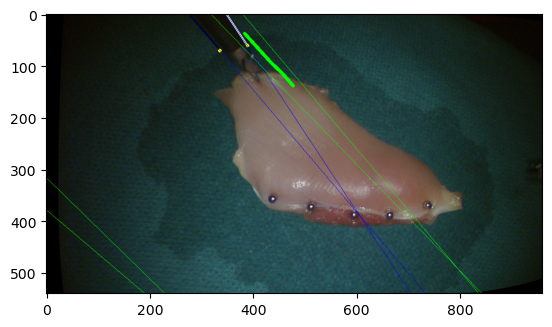

In [159]:
import matplotlib.pyplot as plt

# Check camera projection operators for the left image
# -- Original Projection
projected_l_lines = cam.projectShaftLines_SingleCam(pos_l[-1].unsqueeze(0).cpu().detach().numpy(), 
                                                    dir_l[-1].unsqueeze(0).cpu().detach().numpy(), 
                                                    r[-1].unsqueeze(0).cpu().detach().numpy(), 'left')
l_img = drawPolarLines(l_img, projected_l_lines, color = (255, 0, 0))

# -- New projection equation
(A_1, B_1), (A_2, B_2) = projectShaft_torch(pos_l, dir_l, r, k_1)

# -- Reparamaterize to rho and theta for easy visualization
rho_1 = 1 / torch.sqrt(A_1**2 + B_1**2)
theta_1 = torch.atan2(B_1, A_1)
rho_2 = 1 / torch.sqrt(A_2**2 + B_2**2)
theta_2 = torch.atan2(B_2, A_2)
l_img = drawPolarLines(l_img, np.array([[rho_1[-1].cpu().detach().numpy(), theta_1[-1].cpu().detach().numpy()],
                                        [rho_2[-1].cpu().detach().numpy(), theta_2[-1].cpu().detach().numpy()]]), color = (0, 255, 0))

print("IF YOU DON'T SEE RED, THEN THE PROJECTION EQUATIONS ARE LINED UP!!")

plt.imshow(l_img)

In [189]:
def hat(v: torch.Tensor) -> torch.Tensor:
    """
    Compute the Hat operator [1] of a batch of 3D vectors.

    Args:
        v: Batch of vectors of shape `(minibatch , 3)`.

    Returns:
        Batch of skew-symmetric matrices of shape
        `(minibatch, 3 , 3)` where each matrix is of the form:
            `[    0  -v_z   v_y ]
             [  v_z     0  -v_x ]
             [ -v_y   v_x     0 ]`

    Raises:
        ValueError if `v` is of incorrect shape.

    [1] https://en.wikipedia.org/wiki/Hat_operator
    """

    N, dim = v.shape
    if dim != 3:
        raise ValueError("Input vectors have to be 3-dimensional.")

    h = torch.zeros((N, 3, 3), dtype=v.dtype, device=v.device)

    x, y, z = v.unbind(1)

    h[:, 0, 1] = -z
    h[:, 0, 2] = y
    h[:, 1, 0] = z
    h[:, 1, 2] = -x
    h[:, 2, 0] = -y
    h[:, 2, 1] = x

    return h

def _so3_exp_map(
    log_rot: torch.Tensor, eps: float = 0.0001
) -> torch.Tensor:
    """
    A helper function that computes the so3 exponential map and,
    apart from the rotation matrix.
    """
    _, dim = log_rot.shape
    if dim != 3:
        raise ValueError("Input tensor shape has to be Nx3.")

    nrms = (log_rot * log_rot).sum(1)
    # phis ... rotation angles
    rot_angles = torch.clamp(nrms, eps).sqrt()
    # pyre-fixme[58]: `/` is not supported for operand types `float` and `Tensor`.
    rot_angles_inv = 1.0 / rot_angles
    fac1 = rot_angles_inv * rot_angles.sin()
    fac2 = rot_angles_inv * rot_angles_inv * (1.0 - rot_angles.cos())
    skews = hat(log_rot)
    skews_square = torch.bmm(skews, skews)

    R = (
        fac1[:, None, None] * skews
        # pyre-fixme[16]: `float` has no attribute `__getitem__`.
        + fac2[:, None, None] * skews_square
        + torch.eye(3, dtype=log_rot.dtype, device=log_rot.device)[None]
    )

    return R

In [219]:
# Now time to run the OPTIMIZATION MUHAHAHAHAHAHAHAHAHHAHAHAHA
# Parameters are:
#   - pos : N x 3 position of the shaft in the robot frame
#   - dir : N x 3 direction of the shaft in the robot frame
#   - cam_T_b_to_optimize : 4 x 4 matrix we want to optimize
#   - l_detected_lines : N x 5 x 2  5 lines detected in the left image frame in rho, theta format where NaN means no detection
#   - r_detected_lines : N x 5 x 2  5 lines detected in the right image frame in rho, theta format where NaN means no detection
torch.autograd.set_detect_anomaly(True)

t_device = device

translation_vector = torch.zeros(3).to(t_device)
orientation_vector = torch.zeros(3).to(t_device)
translation_vector.requires_grad = True
orientation_vector.requires_grad = True
optim = torch.optim.SGD([translation_vector, orientation_vector], lr=1e-3)#lr=5e-4)
# optim = torch.optim.Adam([translation_vector, orientation_vector], lr=1e-4)

cost_list = []
min_cost = torch.inf

for i in range(20000):
    # -- Convert detected lines to Ax + By = 1 format (still size N x 5 x 2)
    l_detected_lines_torch = torch.from_numpy(l_detected_lines[:max_num]).to(t_device)
    l_detected_lines_a_b = torch.zeros_like(l_detected_lines_torch)
    l_detected_lines_a_b[:, :, 0] = torch.cos(l_detected_lines_torch[:, :, 1])/ l_detected_lines_torch[:, :, 0]
    l_detected_lines_a_b[:, :, 1] = torch.sin(l_detected_lines_torch[:, :, 1])/ l_detected_lines_torch[:, :, 0]

    r_detected_lines_torch = torch.from_numpy(r_detected_lines[:max_num]).to(t_device)
    r_detected_lines_a_b = torch.zeros_like(r_detected_lines_torch)
    r_detected_lines_a_b[:, :, 0] = torch.cos(r_detected_lines_torch[:, :, 1])/ r_detected_lines_torch[:, :, 0]
    r_detected_lines_a_b[:, :, 1] = torch.sin(r_detected_lines_torch[:, :, 1])/ r_detected_lines_torch[:, :, 0]

    # -- Remove frames where there are not at least 2 lines detected in both the left and right images
    l_not_nan = torch.sum(~torch.isnan(l_detected_lines_a_b[:,:,0]), dim=-1) >= 2
    r_not_nan = torch.sum(~torch.isnan(r_detected_lines_a_b[:,:,0]), dim=-1) >= 2
    not_nan = l_not_nan * r_not_nan
    l_detected_lines_a_b = l_detected_lines_a_b[not_nan, :, :]
    r_detected_lines_a_b = r_detected_lines_a_b[not_nan, :, :]
    pos_filtered = pos.to(t_device)[not_nan, :]
    dir_filtered = dir.to(t_device)[not_nan, :]
    r_filtered = r.to(t_device)[not_nan]

    # -- Replace nans with infinity so the cost for those lines would be infinite
    l_detected_lines_a_b[torch.isnan(l_detected_lines_a_b)] = 100000
    r_detected_lines_a_b[torch.isnan(r_detected_lines_a_b)] = 100000

    # -- Transform insertion shaft parameters to the camera frame with the parameters we want to optimize over
    rot_mat = _so3_exp_map(orientation_vector.unsqueeze(0)).squeeze(0)
    pos_l = torch.matmul(torch.matmul(cam_T_b_to_optimize[:3, :3].to(t_device), rot_mat), pos_filtered.transpose(0,1)).transpose(0,1) + cam_T_b_to_optimize[:3, -1].to(t_device) + translation_vector
    dir_l = torch.matmul(torch.matmul(cam_T_b_to_optimize[:3, :3].to(t_device), rot_mat), dir_filtered.transpose(0,1)).transpose(0,1)

    # -- Also transform to the right camera
    pos_r = torch.matmul(T[:3, :3].to(t_device), pos_l.transpose(0,1)).transpose(0,1)  + T[:3, -1].to(t_device)
    dir_r = torch.matmul(T[:3, :3].to(t_device), dir_l.transpose(0,1)).transpose(0,1)

    # -- Project to get lines in left image
    (l_A_1, l_B_1), (l_A_2, l_B_2) = projectShaft_torch(pos_l, dir_l, r_filtered, k_1.to(t_device))
    l_projected_lines_a_b_1 = torch.stack([l_A_1, l_B_1], dim=1)
    l_projected_lines_a_b_2 = torch.stack([l_A_2, l_B_2], dim=1)

    # -- Project to get lines in the right image
    (r_A_1, r_B_1), (r_A_2, r_B_2) = projectShaft_torch(pos_r, dir_r, r_filtered, k_2.to(t_device))
    r_projected_lines_a_b_1 = torch.stack([r_A_1, r_B_1], dim=1)
    r_projected_lines_a_b_2 = torch.stack([r_A_2, r_B_2], dim=1)

    # -- Want to associate projected lines with detected lines
    ## - l_detected_lines_a_b is N x 5 x 2
    ## - l_projected_lines_a_b_1 is N x 2
    ## - l_projected_lines_a_b_2 is N x 2
    # - l_cost is N x 5 which corresponds to the cost of one projected shaft line to all 5 detections
    l_cost_1 = torch.mean((l_detected_lines_a_b - l_projected_lines_a_b_1.unsqueeze(1))**2, dim=-1)
    l_cost_2 = torch.mean((l_detected_lines_a_b - l_projected_lines_a_b_2.unsqueeze(1))**2, dim=-1)
    r_cost_1 = torch.mean((r_detected_lines_a_b - r_projected_lines_a_b_1.unsqueeze(1))**2, dim=-1)
    r_cost_2 = torch.mean((r_detected_lines_a_b - r_projected_lines_a_b_2.unsqueeze(1))**2, dim=-1)

    # Now we need to find which matching pair of lines will minimize the total
    # - l_cost_matrix should be N x 5 x 5
    # - Diagonal is made infinity so when picking the minimum, both lines are note associated to the same line
    l_cost_matrix = l_cost_1.unsqueeze(-1) + l_cost_2.unsqueeze(1)
    diag_mask = torch.eye(5).unsqueeze(0).repeat(l_cost_matrix.shape[0], 1, 1).to(torch.bool)
    l_cost_matrix[diag_mask] = torch.inf
    r_cost_matrix = r_cost_1.unsqueeze(-1) + r_cost_2.unsqueeze(1)
    r_cost_matrix[diag_mask] = torch.inf


    # -- Find minimum cost for association
    l_cost, l_associated_lins = torch.min(torch.flatten(l_cost_matrix, start_dim=-2, end_dim=-1), dim=-1)
    r_cost, r_associated_lins = torch.min(torch.flatten(r_cost_matrix, start_dim=-2, end_dim=-1), dim=-1)


    # -- Get mean and backpropogate?
    cost = torch.mean(l_cost) + torch.mean(r_cost)
    cost.backward()

    cost_list.append(cost.item())

    print(cost)
    print(translation_vector.grad)
    print(orientation_vector.grad)

    if cost < min_cost:
        min_cost = cost.detach()
        best_translation = translation_vector.detach()
        best_orientation = orientation_vector.detach()

    optim.step()

tensor(9.8287e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 6.0453e-05, -6.6257e-05,  1.3360e-05], device='cuda:0')
tensor([-5.0142e-07,  6.7068e-06,  6.9682e-07], device='cuda:0')
tensor(9.8286e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 1.2090e-04, -1.3251e-04,  2.6720e-05], device='cuda:0')
tensor([-1.0028e-06,  1.3414e-05,  1.3936e-06], device='cuda:0')
tensor(9.8284e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 1.8134e-04, -1.9875e-04,  4.0077e-05], device='cuda:0')
tensor([-1.5042e-06,  2.0120e-05,  2.0904e-06], device='cuda:0')
tensor(9.8282e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 2.4176e-04, -2.6498e-04,  5.3432e-05], device='cuda:0')
tensor([-2.0057e-06,  2.6827e-05,  2.7872e-06], device='cuda:0')
tensor(9.8278e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 3.0216e-04, -3.3118e-04,  6.678

KeyboardInterrupt: 

tensor([ 0.0092,  0.0078, -0.0037], device='cuda:0')
tensor([ 0.0089, -0.1353, -0.0140], device='cuda:0')


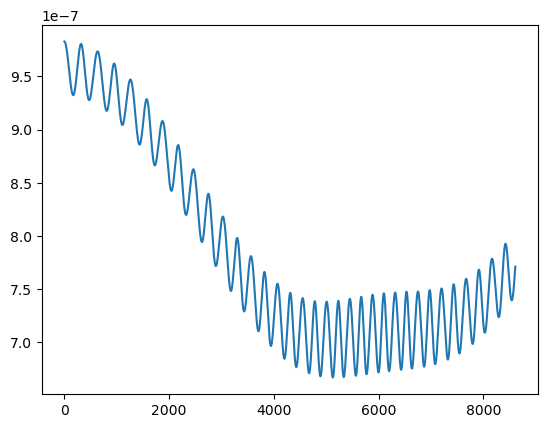

In [220]:
import matplotlib.pyplot as plt
print(best_translation)
print(best_orientation)
plt.plot(np.array(cost_list))

In [221]:
def drawABLines(img, lines, color = (0, 0, 255)):
    lines = lines.reshape(-1, 2)
    for i in range(lines.shape[0]):
        # ax + by - 1 = 0
        a = lines[i, 0]
        b = lines[i, 1]

        # Normalize to cos(theta)x + sin(theta)y - rho = 0
        # That way the image plots nicely and consisntely with our previous function
        den = np.sqrt(a**2 + b**2)
        rho = 1/den
        a = a/den
        b = b/den

        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
        pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))

        # BGR (255, 0, 0) = Blue
        cv2.line(img, pt1, pt2, color, 1)

    return img

In [229]:
frame_counter = 0
line_counter  = 0

# Video output writer
video_out  = cv2.VideoWriter("handeye_new.mp4",  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 30, (int(img_dims[0]*2), img_dims[1]))

# Params for sync approach
old_l_img_msg = None
old_r_img_msg = None
l_img_msg = None
r_img_msg = None
j_msg = None
g_msg = None

for topic, msg, t in bag.read_messages(topics=[left_camera_topic, right_camera_topic, robot_joint_topic, robot_gripper_topic]):
    # Store new messages
    if topic == left_camera_topic:
        old_l_img_msg = copy.deepcopy(l_img_msg)
        l_img_msg = copy.deepcopy(msg)
        l_img_t = t
    if topic == right_camera_topic:
        old_r_img_msg = copy.deepcopy(r_img_msg)
        r_img_msg = copy.deepcopy(msg)
        r_img_t = t
    if topic == robot_joint_topic:
        j_msg = copy.deepcopy(msg)
        j_msg_t = t
    if topic == robot_gripper_topic:
        g_msg = copy.deepcopy(msg)
        g_msg_t = t
    
    # Sync
    if ((l_img_msg != None) and (r_img_msg != None)) and ((l_img_msg != old_l_img_msg) and (r_img_msg != old_r_img_msg)) \
        and (j_msg) and (g_msg):
        try:
            l_img  = np.ndarray(shape=(l_img_msg.height, l_img_msg.width, 3), dtype=np.uint8, buffer=l_img_msg.data)
            r_img = np.ndarray(shape=(r_img_msg.height, r_img_msg.width, 3), dtype=np.uint8, buffer=r_img_msg.data)
            new_joint_angles = np.array(j_msg.position + g_msg.position)
        except:
            continue

        # Previously did not have this !!!!
        old_l_img_msg = copy.deepcopy(l_img_msg)
        old_r_img_msg = copy.deepcopy(r_img_msg)

    else:
        continue
    
    # Update robot joint angles
    robot_arm.updateJointAngles(new_joint_angles)

    # Pre-process the images
    l_img, r_img = cam.processImage(l_img, r_img, crop_scale = crop_scale)

    # If we used the lines here for estimation, use the projected results!
    if not_nan[frame_counter]:

        # Draw projected left and right line from the final optimization loop
        l_img = drawABLines(l_img, l_projected_lines_a_b_1[line_counter, :].cpu().detach().numpy(), color = (0, 255, 0))
        l_img = drawABLines(l_img, l_projected_lines_a_b_2[line_counter, :].cpu().detach().numpy(), color = (255, 255, 0))

        
        r_img = drawABLines(r_img, r_projected_lines_a_b_1[line_counter, :].cpu().detach().numpy(), color = (0, 255, 0))
        r_img = drawABLines(r_img, r_projected_lines_a_b_2[line_counter, :].cpu().detach().numpy(), color = (255, 255, 0))

        
        # Want to somehow draw the associated detected line....
        l_associated_1 = l_associated_lins[line_counter] // l_cost_matrix.shape[-2]
        l_associated_2 = l_associated_lins[line_counter] % l_cost_matrix.shape[-1]
        l_img = drawABLines(l_img, l_detected_lines_a_b[line_counter, l_associated_1, :].cpu().detach().numpy(), color = (0, 255, 0))
        l_img = drawABLines(l_img, l_detected_lines_a_b[line_counter, l_associated_2, :].cpu().detach().numpy(), color = (255, 255, 0))

        r_associated_1 = r_associated_lins[line_counter] // r_cost_matrix.shape[-2]
        r_associated_2 = r_associated_lins[line_counter] % r_cost_matrix.shape[-1]
        r_img = drawABLines(r_img, r_detected_lines_a_b[line_counter, r_associated_1, :].cpu().detach().numpy(), color = (0, 255, 0))
        r_img = drawABLines(r_img, r_detected_lines_a_b[line_counter, r_associated_2, :].cpu().detach().numpy(), color = (255, 255, 0))

        line_counter += 1


    # Plot skeleton of surgical tool
    new_cam_T_b  = cam_T_b.copy()
    new_cam_T_b[:3, -1] += best_translation.cpu().detach().numpy()
    new_cam_T_b[:3, :3] = np.dot(new_cam_T_b[:3, :3], _so3_exp_map(best_orientation.unsqueeze(0)).squeeze(0).cpu().detach().numpy())
    img_list = projectSkeleton(robot_arm.getSkeletonPoints(), cam_T_b,     [l_img, r_img], cam.projectPoints, color = (255, 0, 0))
    img_list = projectSkeleton(robot_arm.getSkeletonPoints(), new_cam_T_b, [l_img, r_img], cam.projectPoints, color = (0, 0, 255))
    new_cam_T_b[:3, -1] += dir_l[0].cpu().detach().numpy()*0.038
    img_list = projectSkeleton(robot_arm.getSkeletonPoints(), new_cam_T_b, [l_img, r_img], cam.projectPoints, color = (0, 255,0 ))

    # Write image to video here
    img_to_disp = np.concatenate([l_img, r_img], axis=1)
    img_to_disp = cv2.cvtColor(img_to_disp, cv2.COLOR_BGR2RGB)
    video_out.write(img_to_disp)

    frame_counter += 1

    if frame_counter >= max_num:
        break

video_out.release()

text_string: None,None,453,141,,

Function projectSkeleton Took 0.0012 seconds
text_string: None,None,437,216,,

Function projectSkeleton Took 0.0010 seconds
text_string: None,None,373,137,,

Function projectSkeleton Took 0.0007 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0009 seconds
text_string: None,None,437,216,,

Function projectSkeleton Took 0.0006 seconds
text_string: None,None,373,137,,

Function projectSkeleton Took 0.0007 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0008 seconds
text_string: None,None,437,216,,

Function projectSkeleton Took 0.0006 seconds
text_string: None,None,373,137,,

Function projectSkeleton Took 0.0007 seconds
text_string: None,None,453,141,,

Function projectSkeleton Took 0.0008 seconds
text_string: None,None,437,216,,

Function projectSkeleton Took 0.0006 seconds
text_string: None,None,373,137,,

Function projectSkeleton Took 0.0007 seconds
text_string: None,None,453,141,,

Function projectSk

In [209]:
video_out.release()

In [230]:
print(new_cam_T_b)

[[-0.76304683  0.6372871   0.10781795 -0.05953122]
 [ 0.55504649  0.73155852 -0.39591103 -0.06275844]
 [-0.33118412 -0.2422547  -0.91193735  0.05295889]
 [ 0.          0.          0.          1.        ]]
